<a href="https://colab.research.google.com/github/mahdiBerranem/Comment-Analysis/blob/main/comments_Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/grive')

Mounted at /content/grive


In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
toxic_comments = pd.read_csv("/content/grive/MyDrive/Colab Notebooks/train.csv")


In [ ]:
toxic_comments.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()


In [ ]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]


In [ ]:
toxic_comments_labels.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


## **Preprocessing**

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

## **split data**

In [ ]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


## **tokenizer/padding**

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



## **GloVe**

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/grive/MyDrive/Colab Notebooks/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        

In [ ]:
embeddings_dictionary['oxygen']

# **Models archutecture**

In [ ]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          14824300  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


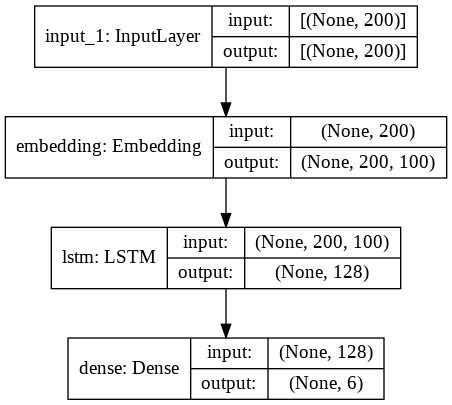

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='/content/grive/MyDrive/model.png', show_shapes=True, show_layer_names=True)

## **Training Model**

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2)


Epoch 1/2
798/798 [==============================] - 525s 655ms/step - loss: 0.1415 - acc: 0.9714 - val_loss: 0.0942 - val_acc: 0.9940
Epoch 2/2
798/798 [==============================] - 525s 658ms/step - loss: 0.0977 - acc: 0.9872 - val_loss: 0.0826 - val_acc: 0.9943


In [26]:
model_test_score = model.evaluate(X_test, y_test, verbose = 1)
print('Test loss:', model_test_score[0])
print('Test accuracy:', model_test_score[1])

998/998 [==============================] - 62s 62ms/step - loss: 0.0827 - acc: 0.9941
Test loss: 0.08270185440778732
Test accuracy: 0.9940780401229858


### **Accuracy and Loss plot diagram for training and validation**

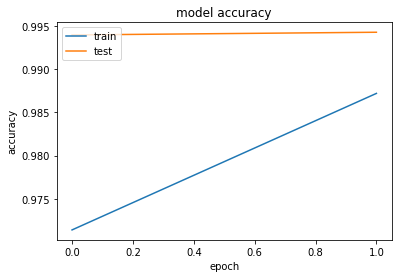

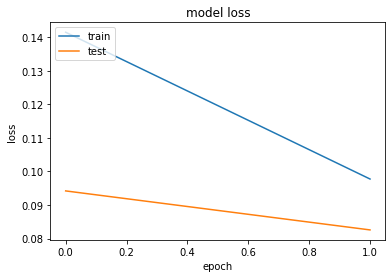

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()